In [10]:
%matplotlib inline
import numpy as np

# Projet optimisation : algorithme SDCA

Plan que je propose : 

On va se concentrer sur l'algorithme SVM avec régularisation LASSO. Etant donné que nous sommes exceptionnellement un groupe constitué de trois personnes, nous vous proposons le sujet 1 enrichi avec le sujet 3. Concrètement, nous allons implémenter 4 méthodes d'optimisations, puis les comparer sur la base de données ... (à choisir) :
- Batch Proximal Gradient Descent (avec accéleration Nesterov, aka FISTA)
- SDCA (avec eventuellement quelques optimisations présentées dans l'article)
- SVRG
- SAGA

*[Partie 1 : Batch Proximal Gradient Descent](#section1)

*[Partie 2 : SDCA](#section2)

*[Partie 3 : SVRG](#section3)

*[Partie 4 : SAGA](#section4)

*[Partie 5 : Comparaison](#section1)

# Définition des données

On commence par définir les données de test (il faudra plus tard mettre les vraies données)

In [386]:
np.random.seed(0)

def binarize(x):
    return np.sign(x)

n_samples, n_features = 1000, 2
X = np.random.randn(n_samples, n_features)
w = np.random.randn(n_features)
b = binarize(X.dot(w) + 0 * np.random.randn(n_samples))

On définit aussi les fonctions de couts et gradient

In [323]:
def f(theta, lam):
    cost = 1-np.multiply(b,X.dot(theta))
    cost[cost <= 0] = 0
    return np.mean(cost) + lam * np.linalg.norm(theta, ord=1)


def partial_grad(theta, i):
    if b[i] * X[i].dot(theta) < 1:
        return -b[i] * X[i]
    return 0 * X[i] 


def grad(theta):
    gradient = -np.multiply(b, X.T)
    
    gradient[:,np.multiply(b, X.dot(theta)) >= 1] = 0 * gradient[:,np.multiply(b, X.dot(theta)) >= 1]
    #print(np.mean(gradient, axis=1))
    return np.mean(gradient, axis=1)
    #gradient = np.zeros(shape=[n_samples, n_features])
    
    #for i in range(n_samples):
    #    gradient[i] = partial_grad(theta, i)
    
    #return np.mean(gradient, axis=0)
    
    #valeur_grad = -np.mean(b,X)
    
    #valeur_grad[np.multiply(b, X.dot(theta)) > 1] = 0
    
    #return valeur_grad

<a id='section1'></a>
Batch Proximal Gradient Descent

In [324]:
def PGD(T, lam):
    # pas de la descente
    # Lipschitz constant
    #L = np.linalg.norm(X.T.dot(X))
    #eta = 1. / L
    eta = 1
    
    # initialisation
    theta = np.zeros(n_features)
    
    # historique de la fonction de perte
    cost_history = np.empty(shape=[T])
    
    for t in range(0,T):
        # compute gradient
        gt = grad(theta)
        
        # compute prox
        theta = theta - eta * gt - eta * lam * np.sign(theta)
        
        cost_history[t] = f(theta, lam)
               
    return theta, cost_history

In [328]:
theta, cost_history = PGD(1000,0)

In [329]:
print(theta)
print(w)

[ 10.7152154   -0.01422075]
[ 0.33004589 -0.00047998]


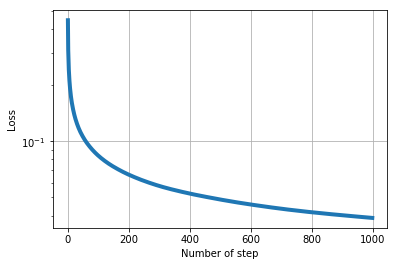

In [330]:
plt.plot(cost_history, lw=4)
plt.grid()
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of step')
plt.show()

On passe à l'accélération Nesterov

In [331]:
def FISTA(T, lam):
    # pas de la descente
    # Lipschitz constant
    #L = np.linalg.norm(X.T.dot(X))
    #eta = 1. / L
    eta = 0.1
    st_moins2 = 1.
    st_moins1 = 1.
    st = 1.
    
    # initialisation
    theta_moins1 = np.zeros(n_features)
    theta = np.zeros(n_features)
    theta_nesterov = np.zeros(n_features)
    
    # historique de la fonction de perte
    cost_history = np.empty(shape=[T])
    
    for t in range(0,T):
        # compute gradient
        gt = grad(theta_nesterov)
        
        # compute st
        st_moins2 = st_moins1
        st_moins1 = st
        st = (1 + np.sqrt(1 + 4 * st**2)) / 2 
        
        # compute prox
        theta_moins1 = theta
        theta = theta_nesterov - eta * gt - eta * lam * np.sign(theta_nesterov)
        
        # compute nestorov acceleration
        theta_nesterov = theta + (st_moins2 / st_moins1) * (theta - theta_moins1)
        
        cost_history[t] = f(theta, lam)
               
    return theta_nesterov, cost_history

In [332]:
theta, cost_history = FISTA(1000,0.01)

In [333]:
print(theta)
print(w)

[  6.19146187e+00  -1.26849063e-03]
[ 0.33004589 -0.00047998]


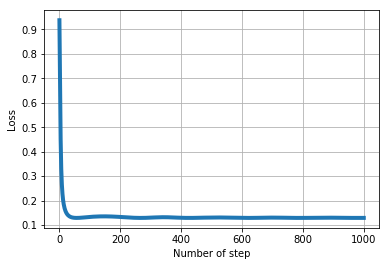

In [334]:
plt.plot(cost_history, lw=4)
plt.grid()
#plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of step')
plt.show()

<a id='section2'></a>
SDCA

Nous allons d'abord implémenter la version la plus classique de l'algorithme, avant de mettre en oeuvre les variantes et améliorations proposées dans http://www.jmlr.org/papers/volume14/shalev-shwartz13a/shalev-shwartz13a.pdf

On définit les fonctions de coût (primal et dual) qui permettront de monitorer l'avancée de l'algorithme. (Remarque : la fonction P est identique que la fonction f définie plus haut, mais on décide de la redéfinir ici pour coller aux notations de l'article)

In [2]:
step_size = 1.0 / (3 * np.max((X * X).sum(1)))      #ici on travaille toujours avec un step_size constant


def P(theta, lam):
    cost = 1-np.multiply(b,X.dot(theta))
    cost[cost <= 0] = 0
    return np.mean(cost) + lam * np.linalg.norm(theta, ord=1)

def D(alpha, lam):
    cost = np.multiply(b,X.dot(theta))
    cost[cost > 0] = np.nan
    cost[cost < -1] = np.nan
    return cost                    

## SCDA classique

In [3]:
def SDCA(T, lam):
    alpha = np.zeros(n_samples)
    w = (1/(lam*n_samples))*np.dot(X.T,alpha)
    
    grad_history = np.empty(shape=[T/100])
    cost_history = np.empty(shape=[T/100])
    
    for t in range(0,T):
        # .. pick random sample ..
        idx = np.random.randint(0, n_samples)
        
        # on calcule les constantes A et B (utiles pour la résolution du delta alpha i)
        A = (1/(lam*n_samples)) * np.linalg.norm(X[idx])**2
        B = X[idx].T.dot(w)    
        
        y_i = b[idx]
        delta_alpha_i_tilde = (y_i-B)/A        
        delta_alpha_i = y_i * np.clip(y_i*(delta_alpha_i_tilde + alpha[idx]), a_min=0, a_max=1) - alpha[idx]
        
        alpha[idx] = alpha[idx] + delta_alpha_i
    
        w = (1/(lam*n_samples))*np.dot(X.T,alpha)
        
        if t % 100 == 0: 
            grad_history[t/100] = delta_alpha_i
            cost_history[t/100] = P(w, lam)
        
    return w, grad_history, cost_history
        

In [4]:
theta, grad_history, cost_history = SDCA(1000,step_size)

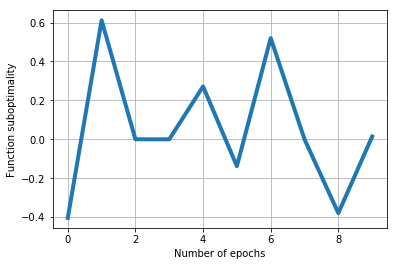

In [5]:
plt.plot(grad_history, lw=4)
plt.grid()
#plt.yscale('log')
plt.ylabel('Function suboptimality')
plt.xlabel('Number of epochs')
plt.show()

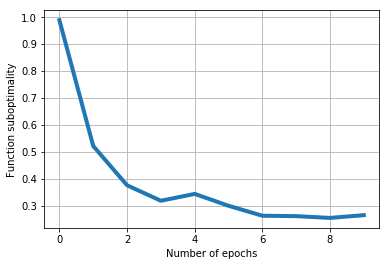

In [6]:
plt.plot(cost_history, lw=4)
plt.grid()
#plt.yscale('log')
plt.ylabel('Function suboptimality')
plt.xlabel('Number of epochs')
plt.show()

## SCDA avec SGD initilisation

In [7]:
...

SyntaxError: invalid syntax (<ipython-input-7-ed20d984b757>, line 1)

<a id='section3'></a>
SVRG

In [387]:
def SVRG(T, m, lam):
    # pas de la descente
    # Lipschitz constant
    #L = np.linalg.norm(X.T.dot(X))
    #eta = 1. / L
    eta = 1
    
    # initialisation
    theta_hat = np.zeros(n_features)
    
    # historique de la fonction de perte
    cost_history = np.empty(shape=[T])
    
    for t in range(0,T):   
        # vrai gradient
        g_hat = grad(theta_hat)
    
        theta = np.zeros([m+1, n_features])
        theta[0,:] = theta_hat
        for k in range(0,m):
            # random sample an indice
            idx = np.random.randint(0, n_samples) 

            # compute variance reduced gradient
            g = partial_grad(theta[k], idx) - partial_grad(theta_hat, idx) + g_hat

            # compute prox
            theta[k+1] = theta[k] - eta * g - eta * lam * np.sign(theta[k])
        
        # on retire la première ligne
        theta = theta[1:]
        
        theta_hat = np.mean(theta, axis=0)
        
        cost_history[t] = f(theta_hat, lam)
               
    return theta_hat, cost_history

In [394]:
theta, cost_history = SVRG(T=100, m=100, lam=0.01)

In [395]:
print(theta)
print(w)

[-3.78327808 -4.96169434]
[-1.53292105 -1.71197016]


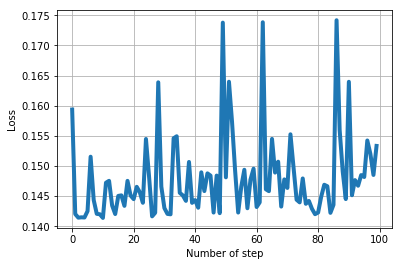

In [396]:
plt.plot(cost_history, lw=4)
plt.grid()
#plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of step')
plt.show()